<p style="font-family: Arial; font-size:3.75em;color:purple; font-style:bold"><br>
$\beta\beta0\nu$ Stuy </p><br>

## Study $\beta\beta0\nu$ multiple tracks

- Shows examples of events where multiple tracks where reconstructed in $\beta\beta0\nu$ events.
- Study dependence with voxelization size

In [1]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

#### General

In [2]:
# General importings
import os
import sys
import glob
import logging
import math
import numpy  as np
import warnings
import functools
import time

from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D 
import networkx as nx
from itertools   import combinations

In [3]:
from pandas import DataFrame, Series
from typing import List, Tuple
from typing import Union
from   dataclasses import dataclass

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"     ] = 14

In [6]:
idx = pd.IndexSlice

#### IC

In [7]:

import invisible_cities.core.system_of_units  as units

from invisible_cities.io.mcinfo_io import load_mcconfiguration
from invisible_cities.io.mcinfo_io import load_mcparticles_df
from invisible_cities.io.mcinfo_io import load_mchits_df
from invisible_cities.io.mcinfo_io import load_mcsensor_positions
from invisible_cities.io.mcinfo_io import load_mcsensor_response_df
from invisible_cities.io.mcinfo_io import get_sensor_types
from invisible_cities.io.mcinfo_io import get_sensor_binning
from invisible_cities.io.mcinfo_io import get_event_numbers_in_file
from invisible_cities.core.core_functions import in_range


#### TICs

In [34]:
from tics.histograms    import h1
from tics.pd_tics       import get_index_slice_from_multi_index
from tics.pd_tics   import slice_and_select_df
from tics.graphics_reco import plot_hits3d
from tics.stats_tics    import bin_data_with_equal_bin_size
from tics.util_tics import get_class_name
from tics.util_tics import Range
from tics.graphics_reco import plot_gtrack
from tics.graphics_reco import plot_gtracks
from tics.system_of_units import *

#### NetFlex

In [9]:
from nextflex.core import Setup

In [10]:
from nextflex.core import Setup
from nextflex.mctrue_functions import get_mc_particles
from nextflex.mctrue_functions import get_mc_primary_particles
from nextflex.mctrue_functions import get_mc_vertex
from nextflex.mctrue_functions import select_mc_particles
from nextflex.mctrue_functions import get_mc_hits
from nextflex.mctrue_functions import select_mc_hits
from nextflex.mctrue_functions import total_hit_energy
from nextflex.mctrue_functions import get_event_hits_from_mchits

In [11]:
from nextflex.reco_functions import voxelize_hits
from nextflex.reco_functions import get_voxels_as_list
from nextflex.reco_functions import voxel_position
from nextflex.reco_functions import voxel_energy
from nextflex.reco_functions import voxel_nhits
from nextflex.reco_functions import distance_between_two_voxels
from nextflex.reco_functions import voxel_distances
from nextflex.reco_functions import voxel_distance_pairs
from nextflex.reco_functions import make_track_graphs
from nextflex.reco_functions import gtrack_voxels
from nextflex.reco_functions import shortest_paths
from nextflex.reco_functions import find_extrema_and_length
from nextflex.reco_functions import GTrack
from nextflex.reco_functions import voxels_in_blob
from nextflex.reco_functions import blob_energy
from nextflex.reco_functions import write_gtracks_json
from nextflex.reco_functions import load_gtracks_json

In [82]:
from nextflex.reco_analysis import reco_gtrack
from nextflex.reco_analysis import reco_gtrack
from nextflex.reco_analysis import reco_gtrack
from nextflex.reco_analysis import reco_gtrack_stats_histos
from nextflex.reco_analysis import reco_gtrack_timing_histos
from nextflex.reco_analysis import reco_gtrack_blobs
from nextflex.reco_analysis import reco_gtrack_blobs_histos
from nextflex.reco_analysis import TrackRecoStats
from nextflex.reco_analysis import TrackRecoTiming
from nextflex.reco_analysis import TrackRecoEventStats
from nextflex.reco_analysis import save_to_JSON
from nextflex.reco_analysis import load_from_JSON
from nextflex.reco_analysis import TrackRecoAnalysisSetup
from nextflex.reco_analysis import GtrkStats
from nextflex.reco_analysis import gtrack_summary
from nextflex.reco_analysis import select_gtrack_topology
from nextflex.reco_analysis import distance_between_extrema
from nextflex.reco_analysis import gtrack_df
from nextflex.reco_analysis import event_list_by_multiplicity

### Input data

In [13]:
FDATA = os.environ['FLEXDATA']

In [14]:
setup = Setup(flexDATA = FDATA,
              sipmPDE  = 1.0,
              maskPDE  = 1.0,
              qTh      = 0.0,
              tpConfig = "FLEX100_M6_O6_EL8bar_bb0nu")
print(setup)


        Setup <FLEX100_M6_O6_EL8bar_bb0nu_PMTs_sipmPDE_1.0_maskPDE_1.0_qTh_0.0>:
        tracking plane configuration = FLEX100_M6_O6_EL8bar_bb0nu
        sipm PDE                     = 1.0
        transmission of teflon masks = 1.0
        charge threshold             = 0.0
        energy sensors               = PMTs
        pitch                        = 15.55
        number of energy sensors     = 60
        number of SiPMs              = 3093
        root directory               = /Users/jj/Development/flexdata/FLEX100_M6_O6_EL8bar_bb0nu
        analysis directory           = /Users/jj/Development/flexdata/analysis/FLEX100_M6_O6_EL8bar_bb0nu
        number of h5 files in dir    = 208
        sipm map at                  = /Users/jj/Development/flexdata/flexmaps/sipm_map_15.6_mm.csv
        sipm map name                = sipm_map_15.6_mm.csv
        output file                  = /Users/jj/Development/flexdata/kdsts/FLEX100_M6_O6_EL8bar_bb0nu_PMTs_sipmPDE_1.0_maskPDE_1.0_qTh_0.0.cs

In [15]:
ifnames = glob.glob(f"{FDATA}/{setup.tpConfig}/*.h5")
print(f'found {len(ifnames)} files')

found 208 files


### Run with large voxels

In [16]:
voxel_bin  = 5
rb         = 5
contiguity =10

In [17]:
gtEvent, trackRecoStats, trackRecoEventStats, trackRecoTiming = reco_gtrack(ifnames[0:10], 
                                                                          voxel_bin, 
                                                                          contiguity,
                                                                          debug=False)

 Total events analyzed = 39,
               Events with a single track = 24


In [55]:
graphTracks = gtrack_df(gtEvent, rb)

In [56]:
gtdf = graphTracks.df
gtdf

event_id  nvox     tlength        x_e1        y_e1  \
evt_number trk_number                                                       
0          0                212    47  128.388471 -161.863903 -410.403261   
           1                212     1    0.000000 -154.306005 -210.879696   
           2                212     1    0.000000 -110.534864 -155.678515   
           3                212     1    0.000000 -107.638045 -171.495649   
1          0                213    61  137.483020 -242.520752  283.138306   
...                         ...   ...         ...         ...         ...   
36         2                565     1    0.000000  215.065533  123.869935   
37         0                566    43   82.041888  358.267153   94.714533   
           1                566     1    0.000000  378.363239   13.377559   
           2                566     2    2.559665  391.596760   52.011911   
38         0                567    51  138.463686  -15.970646 -458.955408   

                             z_e1  energy_e1  nvox_b1   energy_b1        x_e2  \
evt_number trk_number                                                           
0          0           799.438663   0.209614        2  236.709647 -114.430321   
           1           907.142098   0.012581        1   12.581009 -154.306005   
           2           899.274488   0.029781        1   29.781301 -110.534864   
           3           902.835057   0.132281        1  132.281467 -107.638045   
1          0           717.443176   0.007230        3   94.601179 -227.169733   
...                           ...        ...      ...         ...         ...   
36         2           589.905705   0.029724        1   29.723683  215.065533   
37         0           493.089363   0.028835        2   53.802608  392.663000   
           1           709.503611   0.029181        1   29.180594  378.363239   
           2           677.389945   0.021085        2  229.226826  390.891954   
38         0           637.766660   0.291332        3  370.062144   57.869363   

                             y_e2        z_e2  energy_e2  nvox_b2   energy_b2  
evt_number trk_number                                                          
0          0          -433.747009  787.070068   0.048411        4  335.771788  
           1          -210.879696  907.142098   0.012581        1   12.581009  
           2          -155.678515  899.274488   0.029781        1   29.781301  
           3          -171.495649  902.835057   0.132281        1  132.281467  
1          0           278.949920  649.013203   0.104347        4  308.899343  
...                           ...         ...        ...      ...         ...  
36         2           123.869935  589.905705   0.029724        1   29.723683  
37         0            78.849091  453.602904   0.138819        4  527.416437  
           1            13.377559  709.503611   0.029181        1   29.180594  
           2            49.698623  678.228892   0.208142        2  229.226826  
38         0          -453.478158  658.548222   0.194525        3  359.359182  

[63 rows x 15 columns]

In [83]:
est, emt = event_list_by_multiplicity(graphTracks)

In [84]:
est

[1,
 2,
 3,
 4,
 5,
 6,
 8,
 9,
 12,
 13,
 14,
 15,
 17,
 19,
 21,
 22,
 24,
 25,
 26,
 27,
 28,
 30,
 32,
 38]

In [85]:
emt

[0, 7, 10, 11, 16, 18, 20, 23, 29, 31, 33, 34, 35, 36, 37]

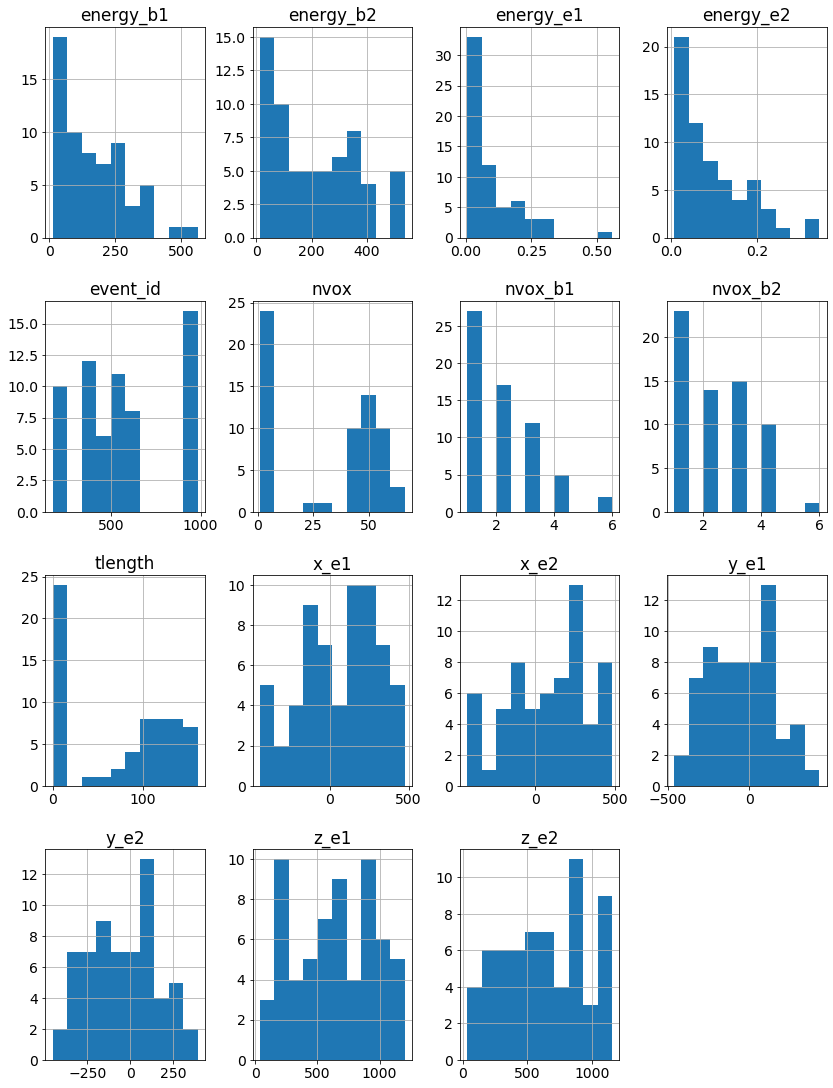

In [58]:
hist = gtdf.hist(figsize = (14,19))

In [66]:
g1tdf = select_gtrack_topology(graphTracks, topology = "single")

In [67]:
g1tdf

,event_id,nvox,tlength,x_e1,y_e1,z_e1,energy_e1,nvox_b1,energy_b1,x_e2,y_e2,z_e2,energy_e2,nvox_b2,energy_b2
evt_number,,,,,,,,,,,,,,,
1,213.0,61.0,137.483020,-242.520752,283.138306,717.443176,0.007230,3.0,94.601179,-227.169733,278.949920,649.013203,0.104347,4.0,308.899343
2,214.0,66.0,144.530775,-140.786118,-67.971995,102.311765,0.557772,2.0,563.045236,-116.036812,-47.284351,63.788048,0.075812,2.0,83.126468
3,215.0,51.0,67.810160,-361.351823,-288.980607,1079.417748,0.045966,2.0,129.653264,-333.010227,-315.316369,1047.702655,0.045498,2.0,74.647058
4,172.0,52.0,111.580567,-214.966620,-344.326786,530.984315,0.253511,1.0,253.511310,-186.550120,-325.893345,553.496637,0.016075,3.0,82.414331
5,173.0,51.0,135.811184,166.666516,102.179322,537.737975,0.288776,2.0,396.491684,176.569347,158.746735,474.481641,0.230331,2.0,299.556769
6,174.0,55.0,131.896789,152.581114,120.465798,733.297714,0.110751,2.0,155.780979,240.890241,141.226476,725.120153,0.177273,3.0,249.328984
8,493.0,44.0,98.708285,77.600990,-50.580749,257.235401,0.123802,3.0,220.484734,104.344762,-82.881848,278.432016,0.105173,4.0,369.237643
9,494.0,49.0,129.242349,-24.860781,290.908328,364.500906,0.301145,3.0,353.126414,-15.637773,350.589386,377.843536,0.006676,4.0,533.187302
12,981.0,31.0,59.334814,-145.343776,-137.605480,647.444406,0.048171,4.0,278.631631,-117.900688,-159.161819,647.762390,0.009720,2.0,297.651805


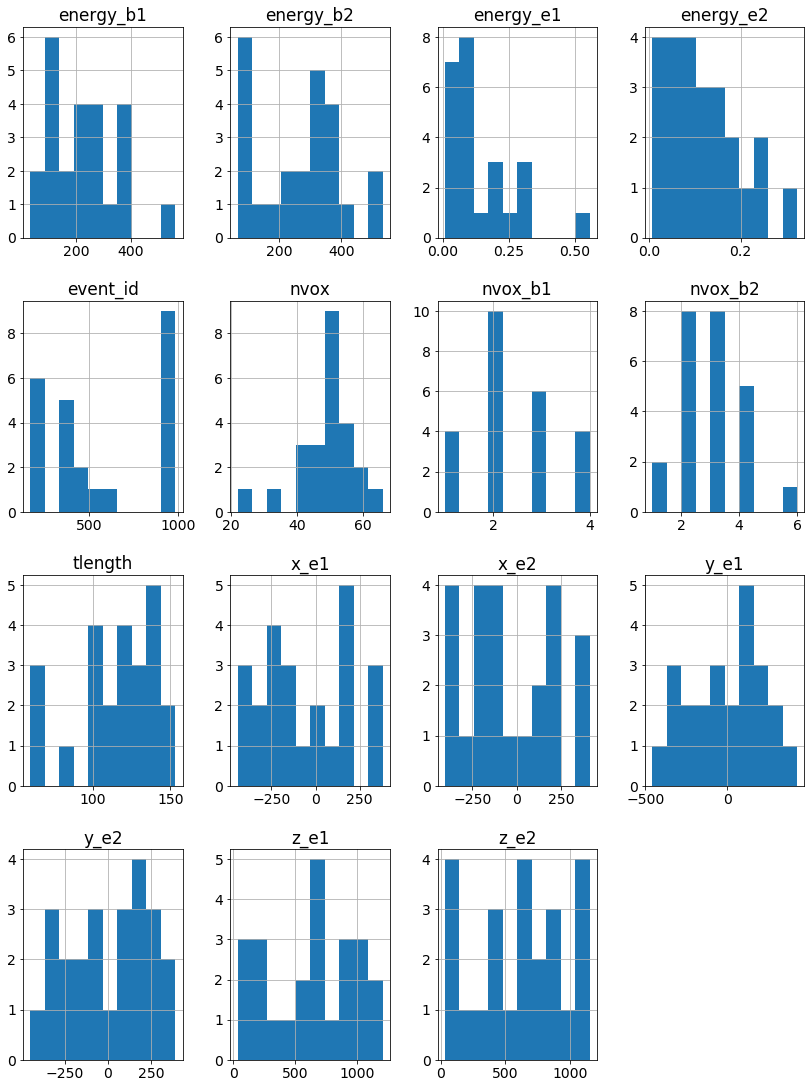

In [68]:
hist = g1tdf.hist(figsize = (14,19))

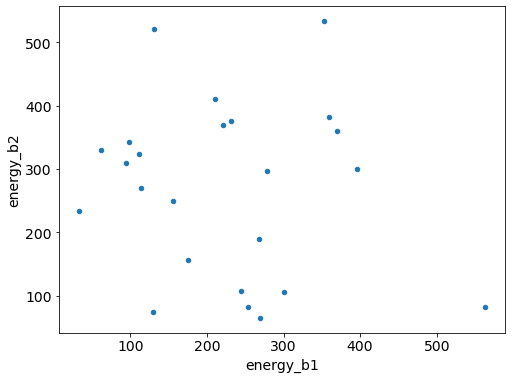

In [69]:
ax1 = g1tdf.plot.scatter(x='energy_b1', y='energy_b2')

In [70]:
gmtdf = select_gtrack_topology(graphTracks, topology = "multiple")

In [71]:
gmtdf

event_id  nvox     tlength        x_e1        y_e1  \
evt_number trk_number                                                       
0          0                212    47  128.388471 -161.863903 -410.403261   
           1                212     1    0.000000 -154.306005 -210.879696   
           2                212     1    0.000000 -110.534864 -155.678515   
           3                212     1    0.000000 -107.638045 -171.495649   
7          0                492    46   98.434080  206.454860 -276.996336   
           1                492     2    7.005907  248.837229 -258.563669   
10         0                495     1    0.000000  145.984961 -276.299499   
           1                495    63  160.520319  158.028143 -282.578733   
11         0                980     1    0.000000  -96.051696  130.909316   
           1                980    44   41.256849  251.801266  131.845783   
           2                980     1    0.000000  259.724532   96.238342   
16         0                353    53  108.629989   14.708194 -348.853412   
           1                353     1    0.000000   11.737600 -298.995373   
18         0                355    55  145.254969   63.445958  -29.575354   
           1                355     1    0.000000   90.326482  -50.569585   
20         0                393     1    0.000000  185.656195 -121.768942   
           1                393     1    0.000000  216.864473 -113.188619   
           2                393    50  125.556044  237.583252 -134.326691   
23         0                948    58  150.587952  315.788887  322.372289   
           1                948     1    0.000000  316.545608  275.636990   
29         0                910     1    0.000000 -422.678231 -199.779947   
           1                910    54  156.750825 -402.123580 -218.789864   
31         0                604    59  155.394529   76.632975   54.252921   
           1                604     1    0.000000  125.986685   79.114789   
33         0                606     1    0.000000  -59.471274   53.698123   
           1                606     3    3.460318  -38.313311   68.875079   
           2                606    45  105.069508  238.986643 -356.541531   
34         0                607    47  134.251249   -5.540110 -207.611056   
           1                607     2    0.574944  216.395999 -141.226011   
35         0                564    46   85.993245  438.022943  -19.026406   
           1                564     1    0.000000  444.240325  -49.546374   
           2                564     1    0.000000  462.917753   -6.859725   
           3                564     1    0.000000  476.072426  -53.378799   
36         0                565    48   86.111757  200.223010  106.999105   
           1                565     1    0.000000  195.434041  111.292166   
           2                565     1    0.000000  215.065533  123.869935   
37         0                566    43   82.041888  358.267153   94.714533   
           1                566     1    0.000000  378.363239   13.377559   
           2                566     2    2.559665  391.596760   52.011911   

                              z_e1  energy_e1  nvox_b1   energy_b1  \
evt_number trk_number                                                
0          0            799.438663   0.209614        2  236.709647   
           1            907.142098   0.012581        1   12.581009   
           2            899.274488   0.029781        1   29.781301   
           3            902.835057   0.132281        1  132.281467   
7          0            176.740243   0.256397        2  307.067182   
           1            157.192918   0.028203        1   28.203167   
10         0           1069.360930   0.049444        1   49.443673   
           1           1093.181911   0.217335        2  239.149867   
11         0           1133.916192   0.143097        1  143.096715   
           1           1081.446221   0.066489        3  142.033471   
           2           11

In [78]:
multipleTrackList = list(np.unique((gmtdf.event_id.values)))
multipleTrackList

[212, 353, 355, 393, 492, 495, 564, 565, 566, 604, 606, 607, 910, 948, 980]

In [72]:
deMT = distance_between_extrema(gmtdf)

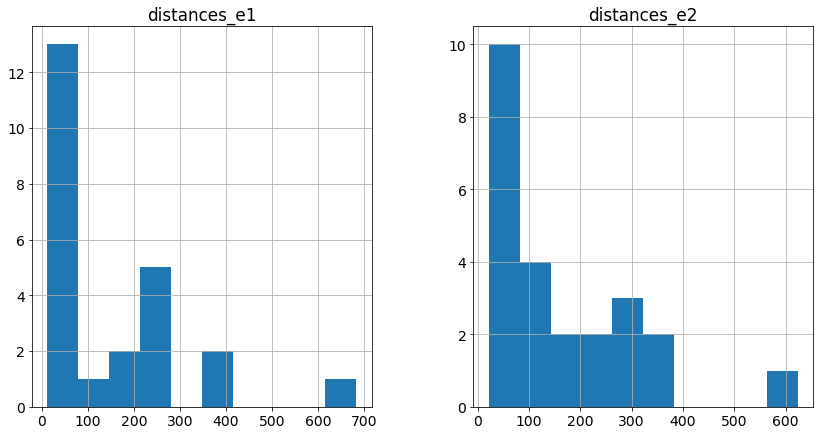

In [73]:
hist = deMT.hist(figsize = (14,7))

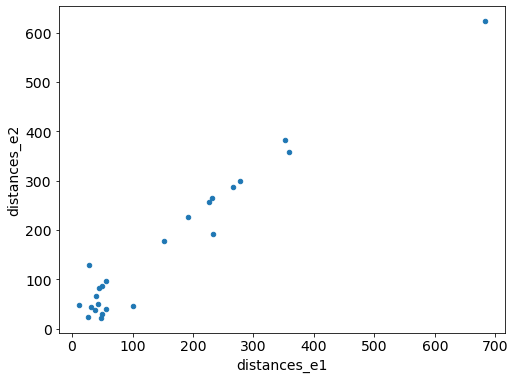

In [74]:
ax1 = deMT.plot.scatter(x='distances_e1', y='distances_e2')

In [97]:
def plot_tracks_list(gtEvent, trackList, figsize = (7,5), fontsize=10):
    for event_number in trackList:
        print(f"event number in gtEvent list  = {event_number}")
        gtrks = gtEvent[event_number]
        
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection='3d')
        
        for i, gt in enumerate(gtrks):
            #print(f" Unique event id = {gt.event_id}, track number = {i}")
            #print(gt)
            ax.set_xlabel('X (mm)')
            ax.set_ylabel('Y (mm)')
            ax.set_zlabel('Z (mm)')
            p = ax.scatter(gt.voxels_df.x, gt.voxels_df.y, gt.voxels_df.z)
        plt.show()


In [98]:
emt

[0, 7, 10, 11, 16, 18, 20, 23, 29, 31, 33, 34, 35, 36, 37]

### Display events with multiple tracks

event number in gtEvent list  = 0


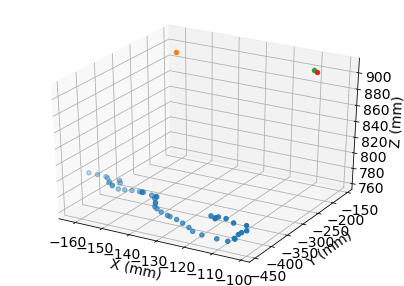

event number in gtEvent list  = 7


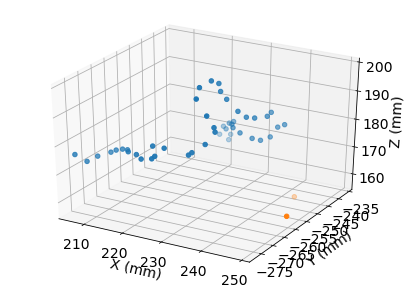

event number in gtEvent list  = 10


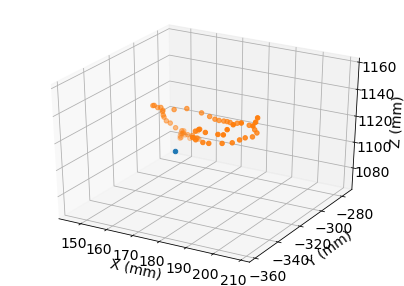

event number in gtEvent list  = 11


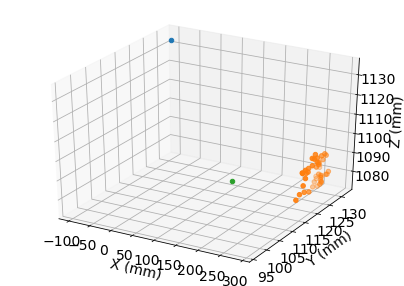

event number in gtEvent list  = 16


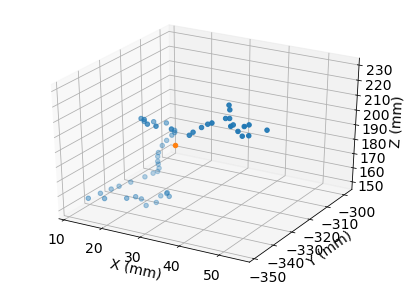

event number in gtEvent list  = 18


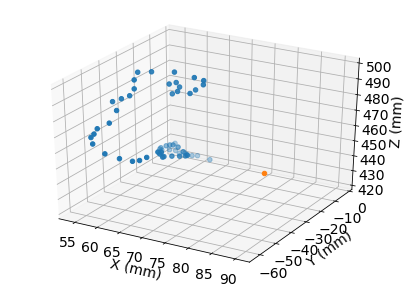

event number in gtEvent list  = 20


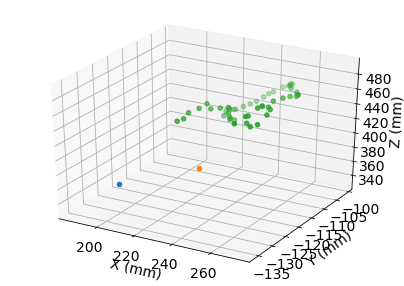

event number in gtEvent list  = 23


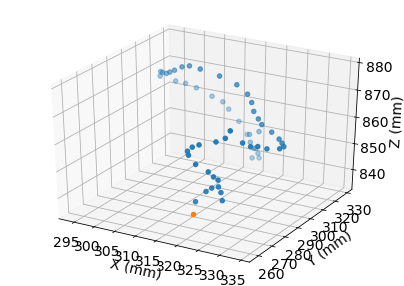

event number in gtEvent list  = 29


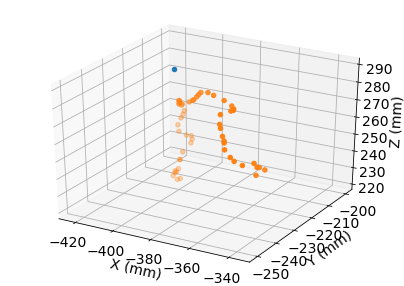

event number in gtEvent list  = 31


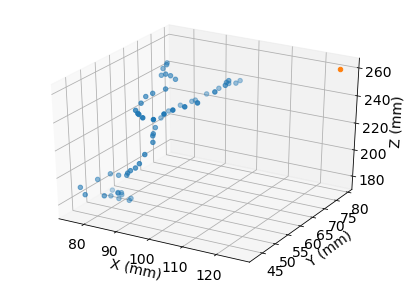

event number in gtEvent list  = 33


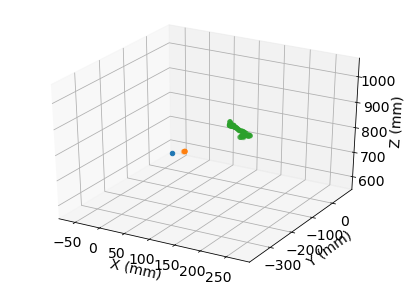

event number in gtEvent list  = 34


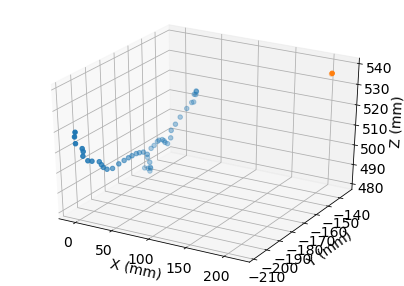

event number in gtEvent list  = 35


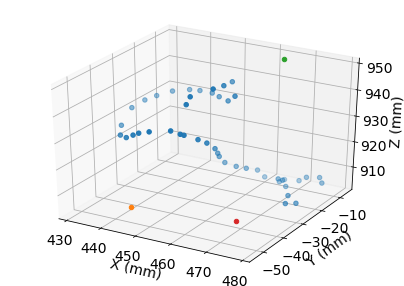

event number in gtEvent list  = 36


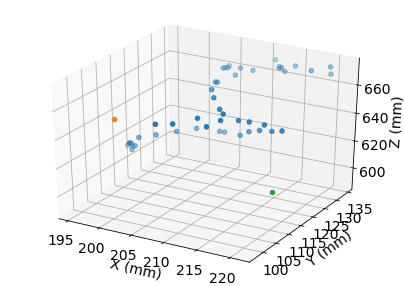

event number in gtEvent list  = 37


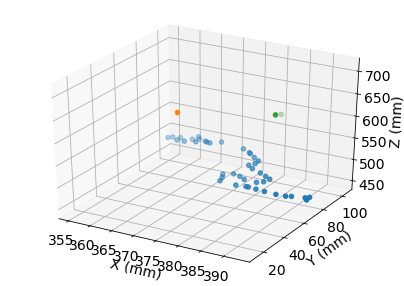

In [99]:
plot_tracks_list(gtEvent, emt)